In [1]:
import copy
import math
import numpy as np
from sympy import *
from sympy.vector import CoordSys3D
from sympy.solvers import solve
from scipy.integrate import ode
import matplotlib.pyplot as plt

In [2]:
# Sympy subs utility
def subs_list(f, sym1, sym2):
    #type(sym1) == list, type(sym2) == list, len(sym1) == len(sym2)
    ans = copy.deepcopy(f)
    for i in range(len(sym1)):
        ans = ans.subs(sym1[i], sym2[i])
    return ans

In [3]:
# Constants
m = list(symbols('m1, m2'))
l = list(symbols('l1, l2'))
g, a, nu = symbols('g, a, nu')

m_num = [1, 1.5]
l_num = [1, 0.75]
g_num = 1
a_num = 2


def set_constants_values(f):
    return subs_list(subs_list(f, m, m_num), l, l_num).subs(g, g_num).subs(a, a_num)

$\overrightarrow{e_x} = \text{base.i}$ , $\overrightarrow{e_y} = \text{base.j}$, $\overrightarrow{e_z} = \text{base.k}$  

In [4]:
# Coordinates
base = CoordSys3D('base')
t = symbols('t')

phi = [Function('phi1')(t), Function('phi2')(t)]
dim = len(phi)
dphi = [diff(phi[i], t) for i in range(dim)]

In [5]:
# Coordinates and velocities
r = [ \
        l[0] * cos(phi[0]) * base.k + l[0] * sin(phi[0]) * base.j + a / nu * cos(nu * t) * base.k, \
        l[0] * cos(phi[0]) * base.k + l[0] * sin(phi[0]) * base.j + a / nu * cos(nu * t) * base.k + \
        l[1] * cos(phi[1]) * base.k + l[1] * sin(phi[1]) * base.j \
    ]
v = [diff(r[i], t) for i in range(dim)]

In [6]:
# Energy and Lagrangian
T = sum([m[i] * v[i].dot(v[i]) / 2 for i in range(dim)])
V = sum([- m[i] * g * r[i].dot(base.k) for i in range(dim)])
L = T - V

In [7]:
# Lagrangian equations
dLddphi = [simplify(diff(L, dphi[i])) for i in range(dim)]
dLdphi = [simplify(diff(L, phi[i])) for i in range(dim)]
eq = [simplify(diff(dLddphi[i], t) - dLdphi[i]) for i in range(dim)]

$$l_{1} \left(a m_{1} \nu \sin{\left(\phi_{1}{\left(t \right)} \right)} \cos{\left(\nu t \right)} + a m_{2} \nu \sin{\left(\phi_{1}{\left(t \right)} \right)} \cos{\left(\nu t \right)} + g m_{1} \sin{\left(\phi_{1}{\left(t \right)} \right)} + g m_{2} \sin{\left(\phi_{1}{\left(t \right)} \right)} + l_{1} m_{1} \frac{d^{2}}{d t^{2}} \phi_{1}{\left(t \right)} + l_{1} m_{2} \frac{d^{2}}{d t^{2}} \phi_{1}{\left(t \right)} + l_{2} m_{2} \sin{\left(\phi_{1}{\left(t \right)} - \phi_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \phi_{2}{\left(t \right)}\right)^{2} + l_{2} m_{2} \cos{\left(\phi_{1}{\left(t \right)} - \phi_{2}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \phi_{2}{\left(t \right)}\right) = 0$$
$$l_{2} m_{2} \left(a \nu \sin{\left(\phi_{2}{\left(t \right)} \right)} \cos{\left(\nu t \right)} + g \sin{\left(\phi_{2}{\left(t \right)} \right)} - l_{1} \sin{\left(\phi_{1}{\left(t \right)} - \phi_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \phi_{1}{\left(t \right)}\right)^{2} + l_{1} \cos{\left(\phi_{1}{\left(t \right)} - \phi_{2}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \phi_{1}{\left(t \right)} + l_{2} \frac{d^{2}}{d t^{2}} \phi_{2}{\left(t \right)}\right)=0$$

In [8]:
# Hamiltonian variables
p = list(symbols('p1, p2'))
q = list(symbols('q1, q2'))
dq = list(symbols('dq1, dq2'))

# Find p(q, dq/dt)
p_expr = [simplify(subs_list(subs_list(diff(L, dphi[i]), dphi, dq), phi, q)) \
              for i in range(dim)]

# Find reverse dq/dt(p, q)
sol = solve([p_expr[i] - p[i] for i in range(dim)], dq)
dq_expr = [simplify(subs_list(subs_list(sol[dq_i], dphi, dq), phi, q)) \
               for dq_i in dq]

# Find Hamiltonian
L_sub = subs_list(subs_list(L, dphi, dq), phi, q)
H = subs_list(sum([p_expr[i] * dq[i] for i in range(dim)]) - L_sub, dq, dq_expr)

In [9]:
def Hamiltonian_eq(H):
    return [- diff(H, q_i) for q_i in q] + \
            [diff(H, p_i) for p_i in p]

In [10]:
#Hamiltonian equations
H_eq = Hamiltonian_eq(H)

In [11]:
# Find average Hamiltonian, averaging on 2 pi / nu period
H_avg = 1 / (2 * pi / nu) * integrate(expand(H), (t, 0, 2 * pi / nu)).subs(sin(2 * pi), 0).subs(cos(2 * pi), 1)

In [12]:
# Average Hamiltonian equations
H_avg_eq = Hamiltonian_eq(H_avg)

In [13]:
# Utility functions
# Implying p = (p1, p2), q = (q1, q2)
def numerical_Hamiltonian_eq(H_eq, nu_val):
    H_lambda_eq = [lambdify([p[0], p[1], q[0], q[1], t], set_constants_values(H_eq_i).subs(nu, nu_val)) \
                    for H_eq_i in H_eq]
    
    return lambda x, y : [H_lambda_eq_i(y[0], y[1], y[2], y[3], x) \
                          for H_lambda_eq_i in H_lambda_eq]

def get_speeds(right_part, solution, t):
    return right_part(t, solution)[dim:]

def integrate_Hamiltonian_system(right_part, initial_values, t_begin, t_step, t_end):
    integr = ode(right_part).set_integrator('dopri5')
    integr.set_initial_value(initial_values, t_begin)
    t_ans = np.array(t_begin)
    #p, q, dq
    traj_ans = [np.array(initial_value) 
                    for initial_value in initial_values] + \
                [np.array(initial_speed_value) \
                     for initial_speed_value in get_speeds(right_part, initial_values, t_begin)]

    while integr.successful() and integr.t < t_end:
        integr.integrate(integr.t + t_step)
        t_ans = np.append(t_ans, integr.t)
        speeds = get_speeds(right_part, integr.y, integr.t)
        traj_ans = [np.append(traj_ans[i], [integr.y[i]]) \
                        for i in range(len(integr.y))] + \
                    [np.append(traj_ans[len(integr.y) + i], [speeds[i]]) \
                         for i in range(len(speeds))]
            
    return t_ans, traj_ans

In [14]:
# Integrate equations

# Initial values
initial_values = [0.1, 0.1, 0.05, -0.03]

N_steps = 1000
t_begin = 0
t_end = 1
t_step = (t_end - t_begin) / N_steps

nu_val = 500

right_part = numerical_Hamiltonian_eq(H_eq, nu_val)
right_part_avg = numerical_Hamiltonian_eq(H_avg_eq, nu_val)

_, traj = integrate_Hamiltonian_system(right_part, initial_values, t_begin, t_step, t_end)
_, traj_avg = integrate_Hamiltonian_system(right_part_avg, initial_values, t_begin, t_step, t_end)

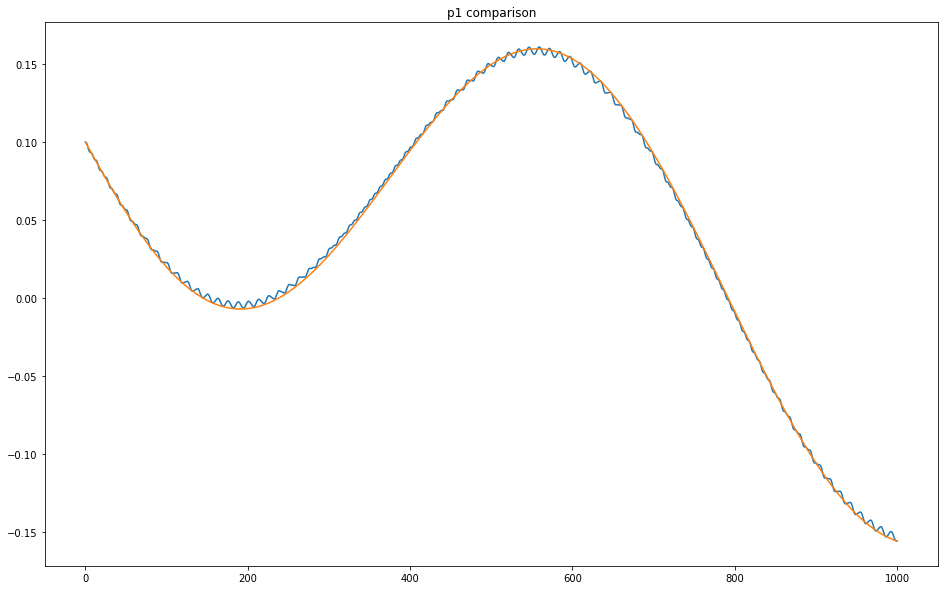

In [15]:
fig = plt.figure(figsize=(16, 10))
plt.plot(traj[0])
plt.plot(traj_avg[0])

plt.title('p1 comparison')
plt.show()

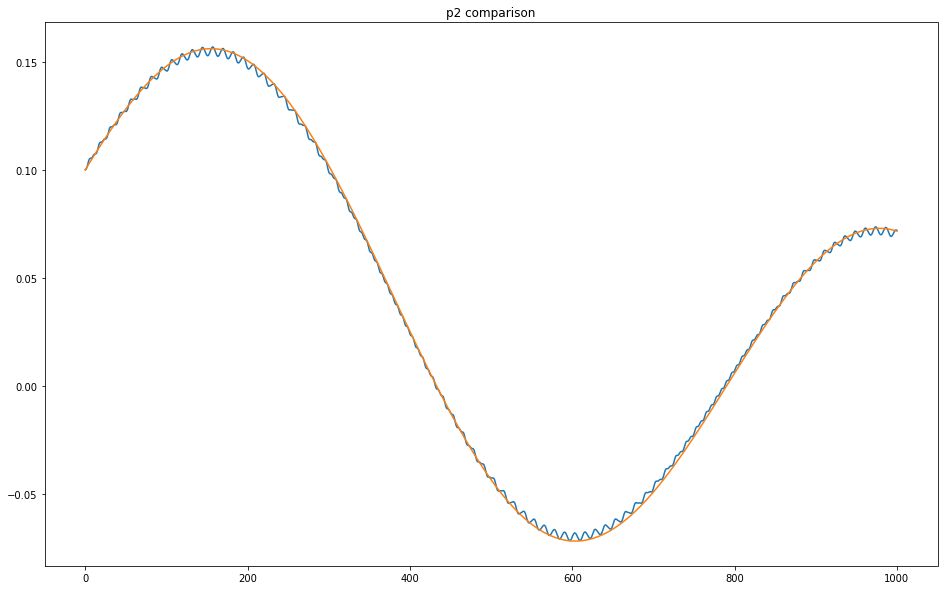

In [16]:
fig = plt.figure(figsize=(16, 10))
plt.plot(traj[1])
plt.plot(traj_avg[1])

plt.title('p2 comparison')
plt.show()

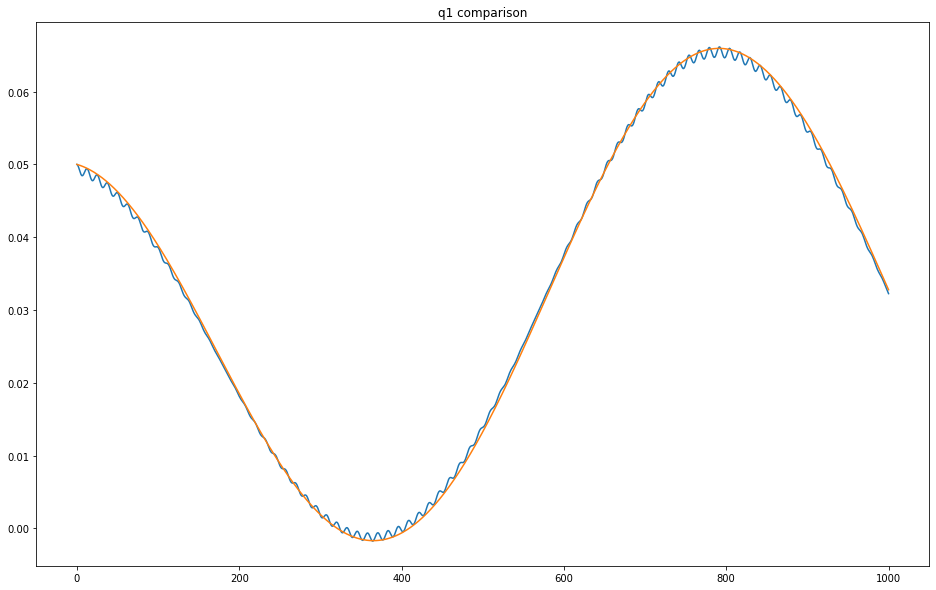

In [17]:
fig = plt.figure(figsize=(16, 10))
plt.plot(traj[2])
plt.plot(traj_avg[2])

plt.title('q1 comparison')
plt.show()

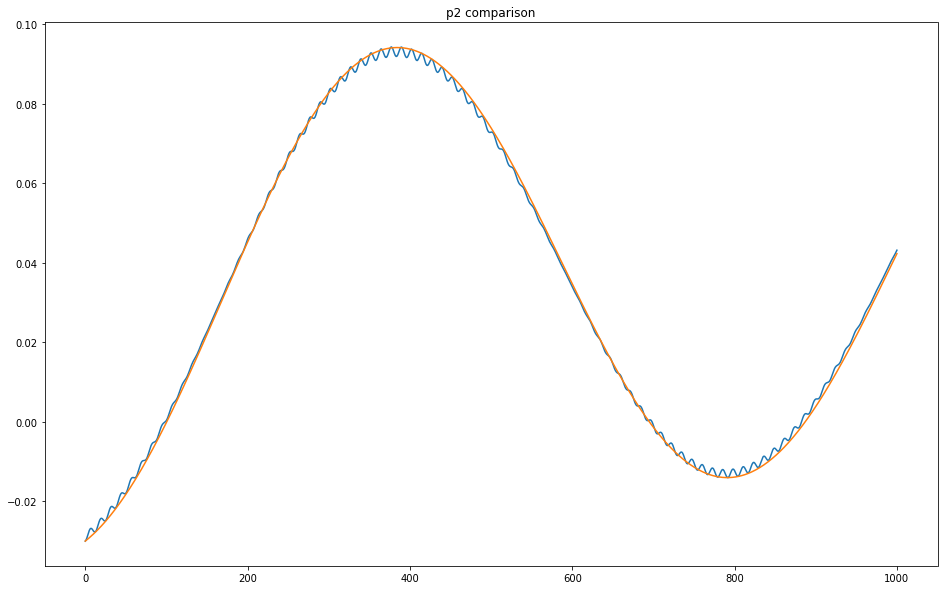

In [18]:
fig = plt.figure(figsize=(16, 10))
plt.plot(traj[3])
plt.plot(traj_avg[3])

plt.title('p2 comparison')
plt.show()

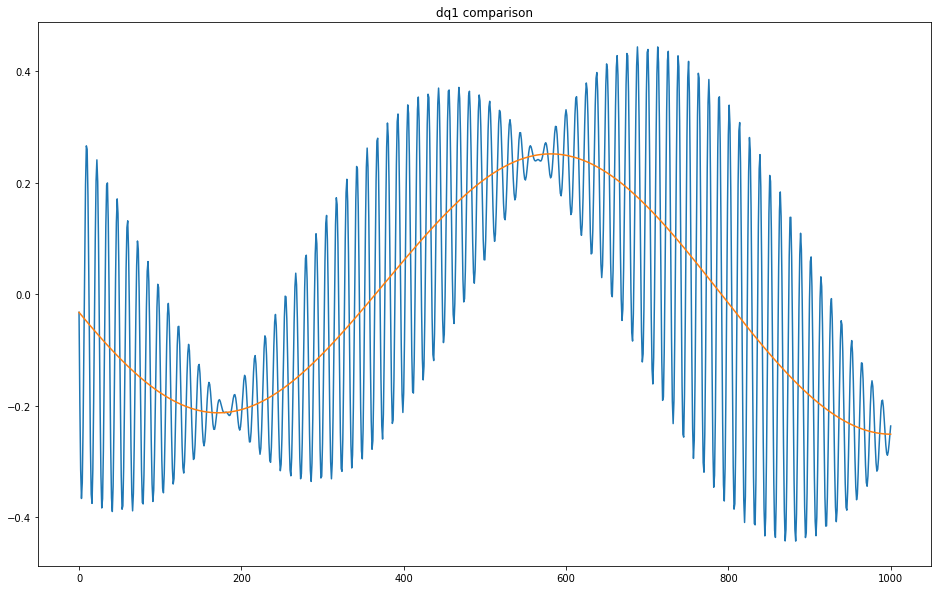

In [19]:
fig = plt.figure(figsize=(16, 10))
plt.plot(traj[4])
plt.plot(traj_avg[4])

plt.title('dq1 comparison')
plt.show()

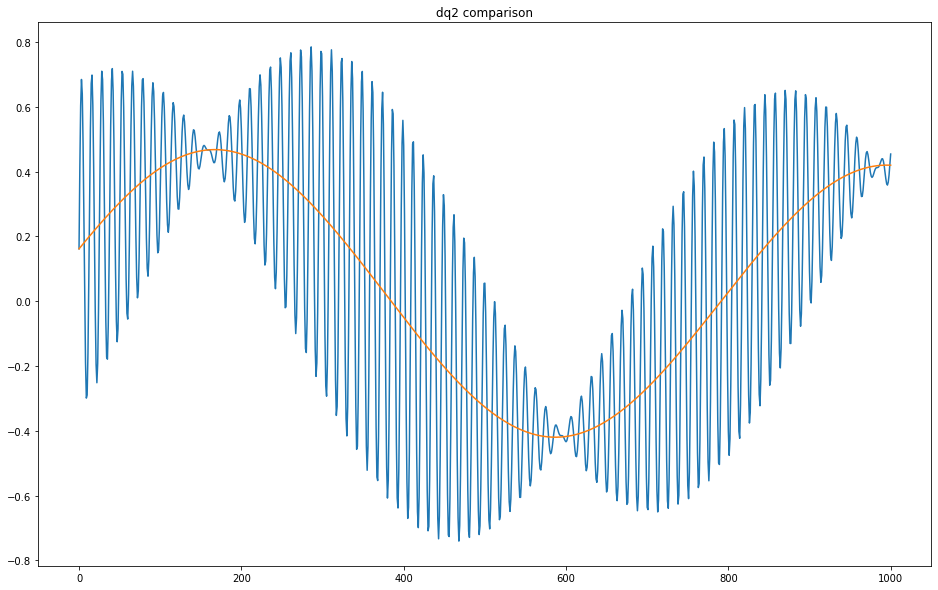

In [20]:
fig = plt.figure(figsize=(16, 10))
plt.plot(traj[5])
plt.plot(traj_avg[5])

plt.title('dq2 comparison')
plt.show()

In [21]:
# Utility function
def get_averaging_error(nu_val, initial_values, t_begin, t_step, t_end):
    right_part = numerical_Hamiltonian_eq(H_eq, nu_val)
    right_part_avg = numerical_Hamiltonian_eq(H_avg_eq, nu_val)

    _, traj = integrate_Hamiltonian_system(right_part, initial_values, t_begin, t_step, t_end)
    _, traj_avg = integrate_Hamiltonian_system(right_part_avg, initial_values, t_begin, t_step, t_end)

    return [np.amax(np.abs(traj[i] - traj_avg[i])) * nu_val for i in range(len(traj))]

In [22]:
# Integrate equations

# Initial values
initial_values = [0.1, 0.1, 0.05, -0.03]

N_steps = 100
t_begin = 0
t_end = 1
t_step = (t_end - t_begin) / N_steps

nu_vals = [1, 2, 5, 10, 25, 50, 75, 100, 150, 200, 500, 750, 1000]
errors = [[], [], [], [], [], []]

for nu_val in nu_vals:
    print(f"Start processing nu={nu_val}")
    error = get_averaging_error(nu_val, initial_values, t_begin, t_step, t_end)
    errors = [errors[i] + [error[i]] for i in range(len(errors))]

Start processing nu=1
Start processing nu=2
Start processing nu=5
Start processing nu=10
Start processing nu=25
Start processing nu=50
Start processing nu=75
Start processing nu=100
Start processing nu=150
Start processing nu=200
Start processing nu=500
Start processing nu=750
Start processing nu=1000


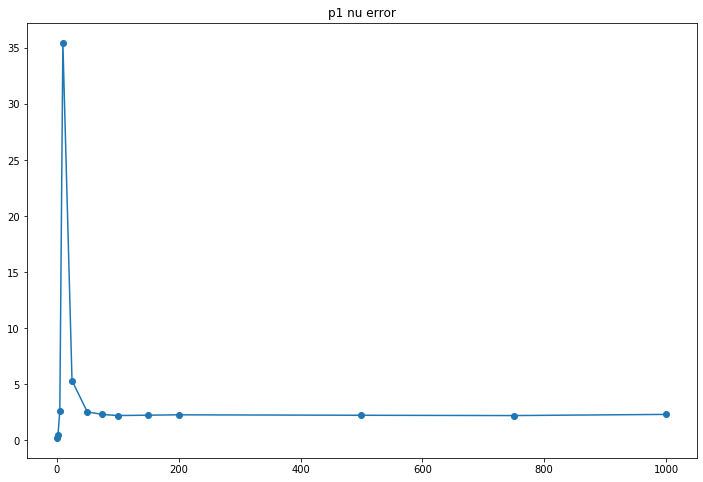

In [23]:
fig = plt.figure(figsize=(12, 8))
plt.plot(nu_vals, errors[0], 'o-')

plt.title('p1 nu error')
plt.show()

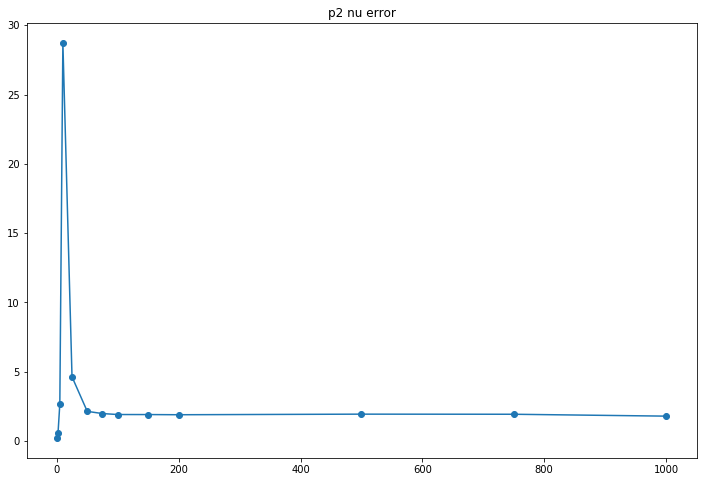

In [24]:
fig = plt.figure(figsize=(12, 8))
plt.plot(nu_vals, errors[1], 'o-')

plt.title('p2 nu error')
plt.show()

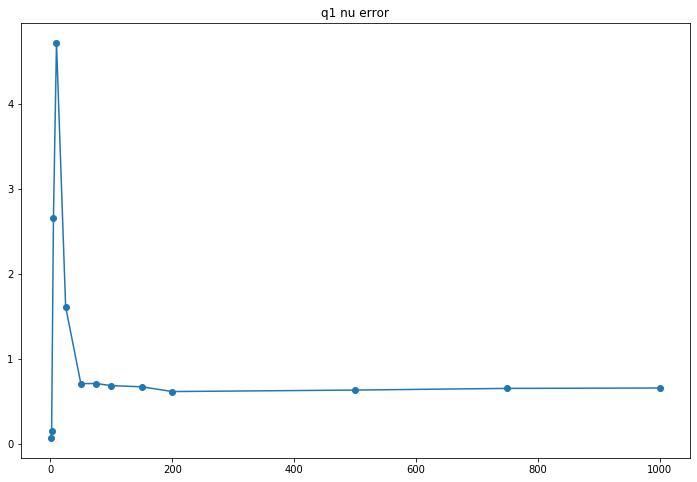

In [25]:
fig = plt.figure(figsize=(12, 8))
plt.plot(nu_vals, errors[2], 'o-')

plt.title('q1 nu error')
plt.show()

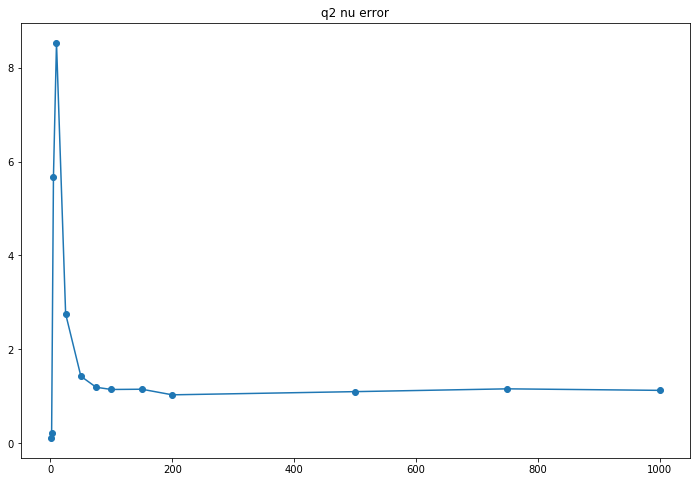

In [26]:
fig = plt.figure(figsize=(12, 8))
plt.plot(nu_vals, errors[3], 'o-')

plt.title('q2 nu error')
plt.show()

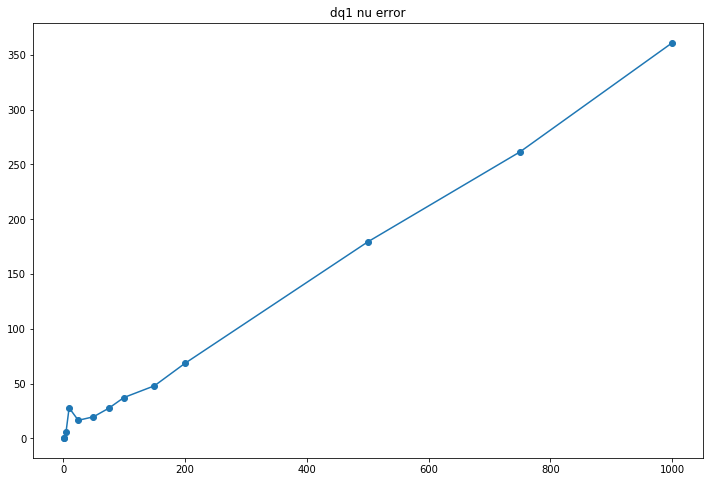

In [27]:
fig = plt.figure(figsize=(12, 8))
plt.plot(nu_vals, errors[4], 'o-')

plt.title('dq1 nu error')
plt.show()

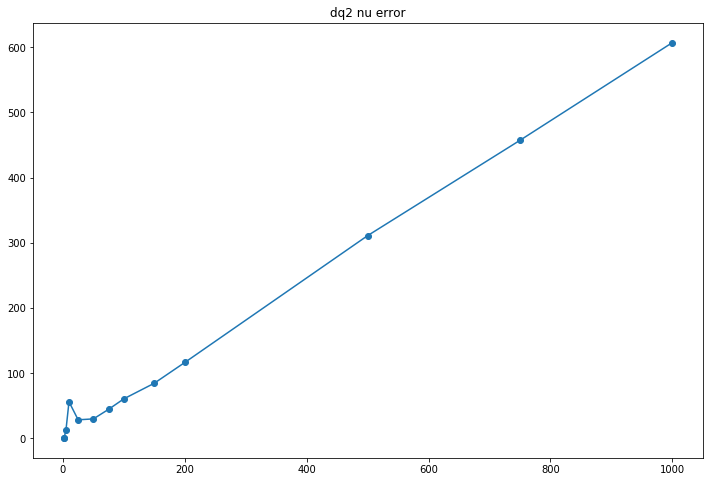

In [28]:
fig = plt.figure(figsize=(12, 8))
plt.plot(nu_vals, errors[5], 'o-')

plt.title('dq2 nu error')
plt.show()